In [9]:
import numpy as np

def generateData(noise_factor, data, labels):
    current_noise = 1

    x = []
    y = []
    z = []

    
    sampled_data = data.copy()
    sampled_labels = labels.copy()
    last = sampled_data

    # noise = np.random.normal(loc=0.0, scale=1.0, size=sampled_data.shape)

    while current_noise >= 0:

        noised = sampled_data *(1-current_noise) + current_noise * np.random.normal(loc=0.0, scale=1.0, size=sampled_data.shape)
        noised = np.clip(noised, 0., 1.)

        y.append(noised)
        x.append(last)
        z.append(sampled_labels)

        last = noised

        current_noise -= noise_factor
    
    return (x, y, z)

In [10]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from keras.utils import to_categorical
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape((len(x_train), 28 * 28)).astype('float32') / 255
x_test = x_test.reshape((len(x_test), 28 * 28)).astype('float32') / 255

# Add noise to the images (optional, but useful for denoising autoencoder)
noise_factor = 0.1

x_train, y_train, l_train = generateData(noise_factor, x_train, y_train)
x_test, y_test, l_test = generateData(noise_factor, x_test, y_test)


# Use the same data for input and target (denoising autoencoder)
l_train = to_categorical(l_train, num_classes=10)
l_test = to_categorical(l_test, num_classes=10)


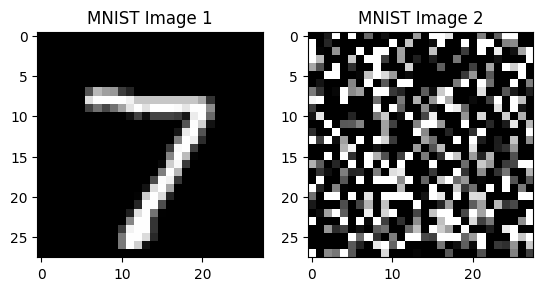

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [55]:
import numpy as np
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(x_test[0][0].reshape(28, 28), cmap='gray')
plt.title('MNIST Image 1')

plt.subplot(1, 2, 2)
plt.imshow(y_test[0][0].reshape(28, 28), cmap='gray')
plt.title('MNIST Image 2')

plt.show()


print(l_test[0][2])

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from keras import layers, models

def layerGroup():
    noise_input = layers.Input(shape=(28 * 28,))
    label_input = layers.Input(shape=(10,))  # Assuming 10 classes for digits 0-9

    # Concatenate noise input with label
    concatenated_input = layers.concatenate([noise_input, label_input])

    x = layers.Dense(28*28, activation='relu')(concatenated_input)
    x = layers.Dense(28*28, activation='relu')(x)
    generated_image = layers.Dense(28*28)(x)

    model = models.Model(inputs=[noise_input, label_input], outputs=generated_image)

    model.compile(optimizer='adam', loss='mse')  # Use appropriate loss function

    return model

chunks = []
for i in range(len(x_test)):
    current = layerGroup()
    current.fit([x_train[i],l_train[i]], y_train[i], epochs=10, batch_size=128)  # Adjust epochs and batch_size
    chunks.append(current)

Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1599
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1586
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1585
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1584
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1584
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1583
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1582
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1581
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1579
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1577
Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1504
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1492
Epoch 3/10
469/469 [=======

In [46]:
def finalModel(chunks):
    noise_input = layers.Input(shape=(28 * 28,))
    label_input = layers.Input(shape=(10,))  # Assuming 10 classes for digits 0-9

    # Concatenate noise input with label
    x = None

    for chunk in chunks:
        if x == None:
            x = layers.concatenate([noise_input, label_input])
        else:
            x = layers.concatenate([x, label_input])
            
        x = layers.Dense(28*28, activation='relu')(x)
        x = layers.Dense(28*28, activation='relu')(x)
        x = layers.Dense(28*28)(x)

    model = models.Model(inputs=[noise_input, label_input], outputs=x)

    model.compile(optimizer='adam', loss='mse')  # Use appropriate loss function

    for i in range(len(chunks)):
        index = i*4
        model.layers[index+3].set_weights(chunks[i].layers[3].get_weights())
        model.layers[index+4].set_weights(chunks[i].layers[4].get_weights())
        model.layers[index+5].set_weights(chunks[i].layers[5].get_weights())

    return model

model = finalModel(chunks)
# model.summary()

# s = ""
# for item in model.layers:
#     s+=str(len(item.get_weights()))+", "
# print(s)

In [11]:
model.fit([x_train[0],l_train[0]], y_train[10], epochs=10, batch_size=128)  # this bad

Epoch 1/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0677
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0537
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0536
Epoch 4/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0536
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0536
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0536
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0535
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0535
Epoch 9/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0535
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0535


In [22]:
# model.save_weights("split-distillation/split-distillation")
# model.load_weights("split-distilaiton/ssplit-distillation")

# model.save("split-distilaiton")


INFO:tensorflow:Assets written to: split-distilaiton2/split-distilaiton2\assets


In [1]:
import tensorflow as tf
model = tf.keras.models.load_model("split-distilaiton")

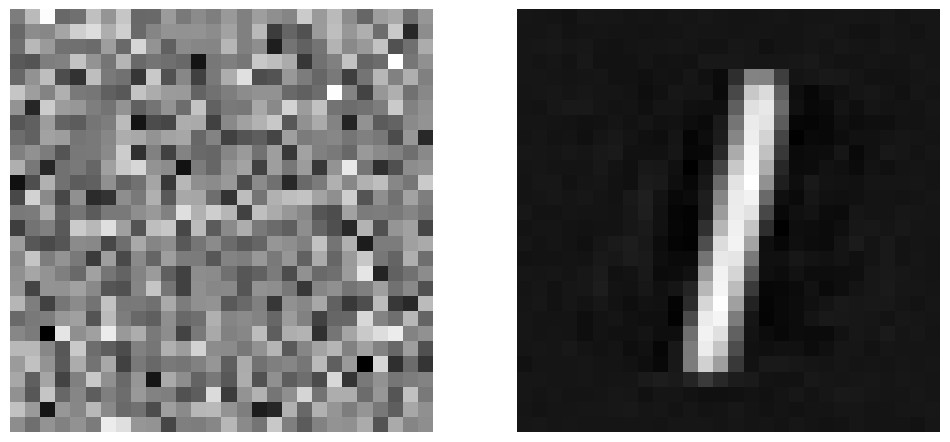

In [5]:
import matplotlib.pyplot as plt
import numpy as np


image = np.array([np.random.normal(loc=0.0, scale=1.0, size=784)])
label = np.array([[0,1,0,0,0,0,0,0,0,0]])


fig, axs = plt.subplots(1, 2, figsize=(12, 6), squeeze=False)
axs[0, 0].imshow(image.reshape(28,28).astype('float'), cmap='gray')
axs[0, 1].imshow(model.predict([image,label],verbose=False).reshape(28, 28).astype('float'), cmap='gray')
for ax in axs[0]:
    ax.axis('off')

plt.show()